In [21]:
install.packages('BiocManager')
BiocManager::install("edgeR")  ##install package edgeR in google colab
install.packages('openxlsx')
#load libraries
library(edgeR)
library(openxlsx)
library(ggplot2)
library(tidyr)
library(dplyr)
library(tidyverse)
BiocManager::install("org.Hs.eg.db")
BiocManager::install("biomaRt")
library(biomaRt)
library(org.Hs.eg.db)
library(statmod)
library(limma)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'edgeR'”
Old packages: 'pbdZMQ', 'evaluate', 'pkgdown', 'tinytex'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE

## Import data, processing, add entrez ID

In [22]:
#import the raw counts file and QC
raw_counts<-read.csv('/content/raw_hyp_md_beforeQC_1.csv')
head(raw_counts)

#check if there are duplicated gene symbols
duplicates_in_rows <- duplicated(raw_counts$gene_name)
raw_counts[duplicates_in_rows, ]## no duplicated gene_symbols

length(raw_counts$gene_name)

,X,gene_name,T6A,T6B,T4UN,T4AD,T4BD,T3D,T4DD,T4DPX,T7A,T1B,T2A,T5AD,T5BD,T5CPX,T5DD,T5DPX
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,A1BG,304,383,241,181,249,242,590,388,257,180,165,129,195,256,325,374
2,2,A1BG-AS1,327,254,216,161,164,229,136,132,237,170,228,155,200,231,139,154
3,3,A1CF,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,A2M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,A2M-AS1,2,1,2,0,0,0,1,0,5,1,1,0,0,0,0,0
6,6,A2ML1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


X,gene_name,T6A,T6B,T4UN,T4AD,T4BD,T3D,T4DD,T4DPX,T7A,T1B,T2A,T5AD,T5BD,T5CPX,T5DD,T5DPX
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


[1] 26475

In [23]:
# assign Ensemble ID and Entrez ID
Gene_symbol<-raw_counts$gene_name
ensembl<-useMart('ensembl',dataset='hsapiens_gene_ensembl')
gene_info<-getBM(attributes=c('hgnc_symbol','ensembl_gene_id','entrezgene_id'),
                 filters='hgnc_symbol',
                 values=Gene_symbol,
                 mart=ensembl)
head(gene_info)


,hgnc_symbol,ensembl_gene_id,entrezgene_id
,<chr>,<chr>,<int>
1,A1BG,ENSG00000121410,1
2,A1BG-AS1,ENSG00000268895,503538
3,A1CF,ENSG00000148584,29974
4,A2M,ENSG00000175899,2
5,A2M-AS1,ENSG00000245105,144571
6,A2ML1,ENSG00000166535,144568


In [24]:
#check NA values
na_in_gene_info <- is.na(gene_info)
na_summary <- colSums(na_in_gene_info)  # Summarize NA count per column
print(na_summary) #no NA values for ensembl ID but 1601 genes have no entrez ID


# most genes with no entrez_ID are non-coding genes
#Extract genes with entrez ID for pathway analysis
na_entrez <- is.na(gene_info$entrezgene_id)
Entrez_gene<-gene_info[!na_entrez, ]
print(dim(Entrez_gene))

#check duplicates of Entrez_gene
duplicates_in_rows <- duplicated(Entrez_gene$hgnc_symbol)
head(Entrez_gene[duplicates_in_rows, ])
print(dim(Entrez_gene[duplicates_in_rows, ]))

#remove duplicates
Entrez_gene<-Entrez_gene[!duplicates_in_rows, ]
print(dim(Entrez_gene))

    hgnc_symbol ensembl_gene_id   entrezgene_id 
              0               0            1601 
[1] 27550     3


,hgnc_symbol,ensembl_gene_id,entrezgene_id
,<chr>,<chr>,<int>
12,AAAS,ENSG00000094914,8086
18,AADACL2,ENSG00000261846,344752
39,AATF,ENSG00000275700,26574
62,ABCB11,ENSG00000073734,8647
70,ABCC1,ENSG00000103222,4363
81,ABCC6,ENSG00000091262,368


[1] 5787    3
[1] 21763     3


In [25]:
#extract raw_counts based on Entrez_gene
Entrez_raw<-raw_counts[raw_counts$gene_name %in% Entrez_gene$hgnc_symbol,]
print(dim(Entrez_raw))
print(head(Entrez_raw))

#re_order raw counts and add the Ensembl ID and Entrez_ID

Entrez_raw<-Entrez_raw[match(Entrez_gene$hgnc_symbol, Entrez_raw$gene_name),]
identical(Entrez_gene$hgnc_symbol,Entrez_raw$gene_name)

Entrez_raw$Ensembl_ID<-Entrez_gene$ensembl_gene_id
Entrez_raw$Entrez_ID<-Entrez_gene$entrezgene_id
print(head(Entrez_raw))

#a quick test

print(Entrez_raw[Entrez_raw$gene_name %in% c('TCF7','PDCD1'),])  #entrez ID correct, ensembl ID correct

[1] 21763    18
  X gene_name T6A T6B T4UN T4AD T4BD T3D T4DD T4DPX T7A T1B T2A T5AD T5BD T5CPX
1 1      A1BG 304 383  241  181  249 242  590   388 257 180 165  129  195   256
2 2  A1BG-AS1 327 254  216  161  164 229  136   132 237 170 228  155  200   231
3 3      A1CF   0   0    0    0    0   0    0     0   0   0   0    0    0     0
4 4       A2M   0   0    0    0    0   0    0     0   0   0   0    0    0     0
5 5   A2M-AS1   2   1    2    0    0   0    1     0   5   1   1    0    0     0
6 6     A2ML1   0   0    0    0    0   0    0     0   0   0   0    0    0     0
  T5DD T5DPX
1  325   374
2  139   154
3    0     0
4    0     0
5    0     0
6    0     0


[1] TRUE

  X gene_name T6A T6B T4UN T4AD T4BD T3D T4DD T4DPX T7A T1B T2A T5AD T5BD T5CPX
1 1      A1BG 304 383  241  181  249 242  590   388 257 180 165  129  195   256
2 2  A1BG-AS1 327 254  216  161  164 229  136   132 237 170 228  155  200   231
3 3      A1CF   0   0    0    0    0   0    0     0   0   0   0    0    0     0
4 4       A2M   0   0    0    0    0   0    0     0   0   0   0    0    0     0
5 5   A2M-AS1   2   1    2    0    0   0    1     0   5   1   1    0    0     0
6 6     A2ML1   0   0    0    0    0   0    0     0   0   0   0    0    0     0
  T5DD T5DPX      Ensembl_ID Entrez_ID
1  325   374 ENSG00000121410         1
2  139   154 ENSG00000268895    503538
3    0     0 ENSG00000148584     29974
4    0     0 ENSG00000175899         2
5    0     0 ENSG00000245105    144571
6    0     0 ENSG00000166535    144568
          X gene_name T6A  T6B T4UN    T4AD T4BD T3D T4DD T4DPX T7A T1B T2A
17839 17839     PDCD1  38  275   75 179.000  375 394  586   594 134 284 127
23315 23315    

## DEG generation

In [26]:
# extract the groups for pathway analysi_focusing on AD and DD groups
Norm_hyp<-Entrez_raw[,c('gene_name','T4AD','T4DD', 'T5AD', 'T5DD','Ensembl_ID','Entrez_ID')]
head(Norm_hyp)


,gene_name,T4AD,T4DD,T5AD,T5DD,Ensembl_ID,Entrez_ID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,A1BG,181,590,129,325,ENSG00000121410,1
2,A1BG-AS1,161,136,155,139,ENSG00000268895,503538
3,A1CF,0,0,0,0,ENSG00000148584,29974
4,A2M,0,0,0,0,ENSG00000175899,2
5,A2M-AS1,0,1,0,0,ENSG00000245105,144571
6,A2ML1,0,0,0,0,ENSG00000166535,144568


In [27]:
# Reassign column names
colnames(Norm_hyp)<-c('gene_name','Normx1_1','Hypx3_1', 'Normx1_2','Hypx3_2', 'Ensembl_ID', 'Entrez_ID')
head(Norm_hyp)

# Convert to edge list
Hyp_Egelist<-DGEList(counts=Norm_hyp[,2:5], genes=Norm_hyp[,1], group=c('Normx1','Hypx3','Normx1','Hypx3'))
#Assign entrez ID and ensembl ID
Hyp_Egelist$genes$Entrez_ID<-Norm_hyp$Entrez_ID
Hyp_Egelist$genes$Ensembl_ID<-Norm_hyp$Ensembl_ID
head(Hyp_Egelist$genes)

,gene_name,Normx1_1,Hypx3_1,Normx1_2,Hypx3_2,Ensembl_ID,Entrez_ID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,A1BG,181,590,129,325,ENSG00000121410,1
2,A1BG-AS1,161,136,155,139,ENSG00000268895,503538
3,A1CF,0,0,0,0,ENSG00000148584,29974
4,A2M,0,0,0,0,ENSG00000175899,2
5,A2M-AS1,0,1,0,0,ENSG00000245105,144571
6,A2ML1,0,0,0,0,ENSG00000166535,144568


,genes,Entrez_ID,Ensembl_ID
,<chr>,<int>,<chr>
1,A1BG,1,ENSG00000121410
2,A1BG-AS1,503538,ENSG00000268895
3,A1CF,29974,ENSG00000148584
4,A2M,2,ENSG00000175899
5,A2M-AS1,144571,ENSG00000245105
6,A2ML1,144568,ENSG00000166535


In [28]:
# QC to remove low counts genes
keep_hyp<-filterByExpr(Hyp_Egelist)
Hyp_QC<-Hyp_Egelist[keep_hyp,,keep.lib.sizes=FALSE]

#Normalize data
Hyp_norm<-normLibSizes(Hyp_QC)

View(Hyp_Egelist$samples)
View(Hyp_QC$samples)
View(Hyp_norm$samples)
View(head(Hyp_norm$genes))
View(dim(Hyp_norm$genes))

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Normx1_1,Normx1,26016922,1
Hypx3_1,Hypx3,28134887,1
Normx1_2,Normx1,27374416,1
Hypx3_2,Hypx3,22884554,1


,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Normx1_1,Normx1,26010864,1
Hypx3_1,Hypx3,28126660,1
Normx1_2,Normx1,27366379,1
Hypx3_2,Hypx3,22875285,1


,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Normx1_1,Normx1,26010864,0.9687941
Hypx3_1,Hypx3,28126660,0.9868038
Normx1_2,Normx1,27366379,1.0208731
Hypx3_2,Hypx3,22875285,1.0246273


,genes,Entrez_ID,Ensembl_ID
,<chr>,<int>,<chr>
1,A1BG,1,ENSG00000121410
2,A1BG-AS1,503538,ENSG00000268895
12,AAAS,8086,ENSG00000291836
13,AACS,65985,ENSG00000081760
23,AAGAB,79719,ENSG00000103591
24,AAK1,22848,ENSG00000115977


[1] 12011     3

,(Intercept),TreatmentB,Time2
Normx1_1,1,0,0
Hypx3_1,1,1,0
Normx1_2,1,0,1
Hypx3_2,1,1,1


,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
Normx1_1,Normx1,26010864,0.9687941
Hypx3_1,Hypx3,28126660,0.9868038
Normx1_2,Normx1,27366379,1.0208731
Hypx3_2,Hypx3,22875285,1.0246273


[1] 0.0223959

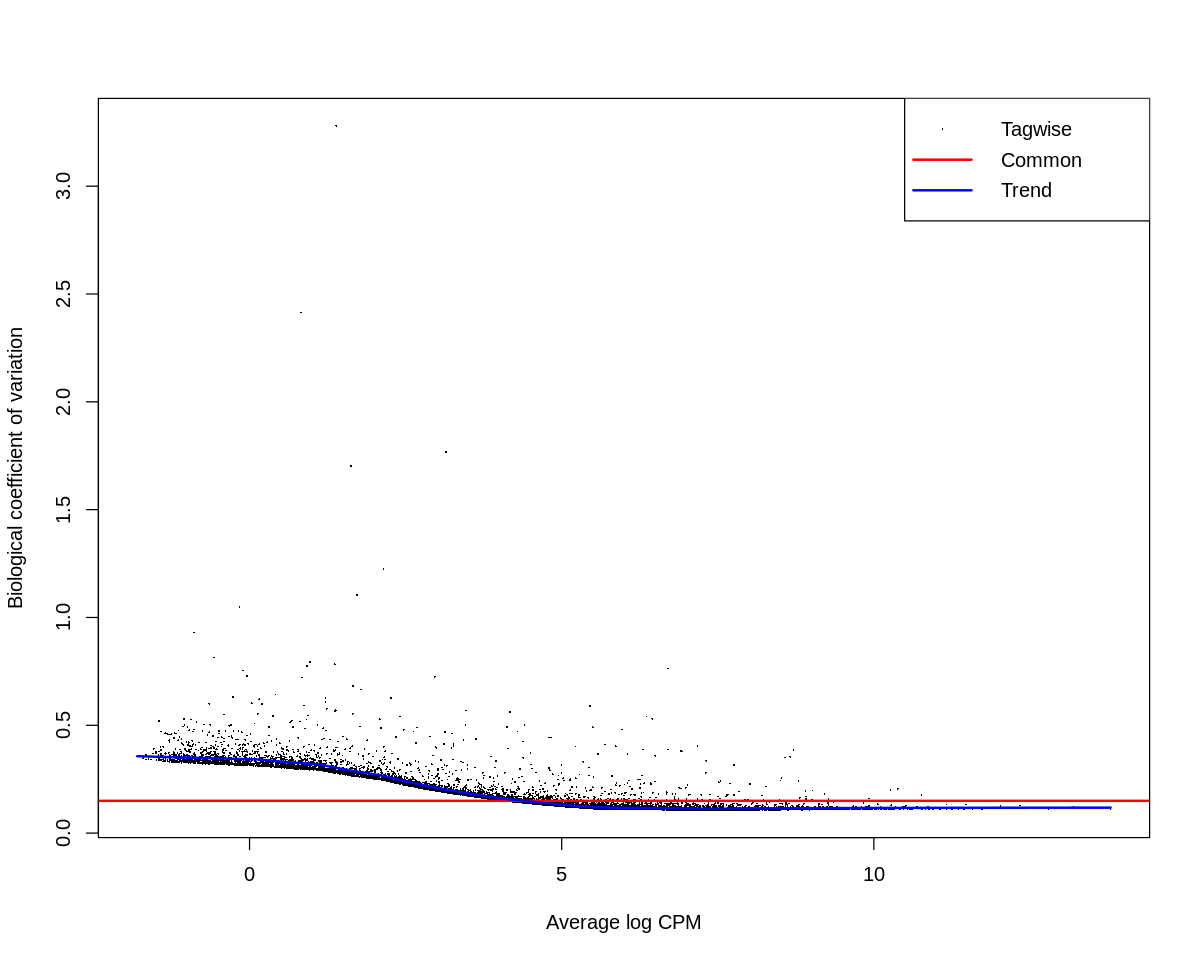

,genes,Entrez_ID,Ensembl_ID,logFC,logCPM,F,PValue,FDR
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18642,PPFIA4,8497,ENSG00000143847,6.074775,5.957481,1145.3920,1.250831e-09,1.502373e-05
13800,MIR210HG,100506211,ENSG00000282810,4.503987,5.193491,600.3949,1.457872e-08,5.077369e-05
16503,NME1,4830,ENSG00000239672,-3.170720,6.885914,581.3151,1.647439e-08,5.077369e-05
24451,TSC22D3,1831,ENSG00000157514,3.816321,7.709854,577.3347,1.690906e-08,5.077369e-05
24165,TP53INP1,94241,ENSG00000164938,3.730559,7.445087,509.4139,3.211607e-08,5.510361e-05
6598,FGFBP2,83888,ENSG00000137441,3.897315,5.071538,477.3496,3.474043e-08,5.510361e-05
16544,NOL3,8996,ENSG00000140939,3.488392,5.433630,473.9577,3.568907e-08,5.510361e-05
15990,MYO18B,84700,ENSG00000133454,3.301060,5.592857,454.8889,4.168009e-08,5.510361e-05
19250,PTPRF,5792,ENSG00000142949,7.381895,3.486145,332.4347,4.377104e-08,5.510361e-05


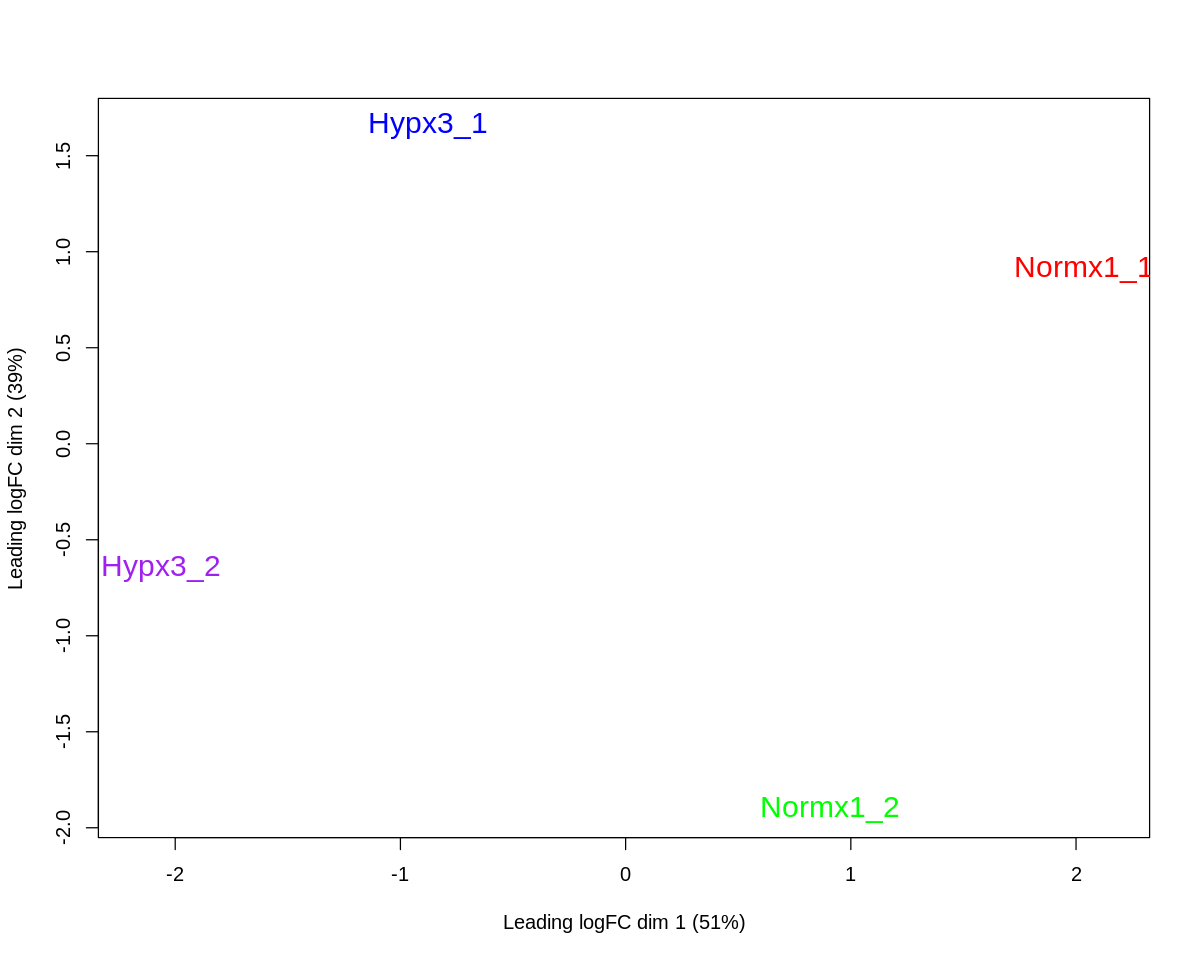

In [53]:
## Get the DEG
#Experiment design
data_use<-data.frame(Treatment=factor(c("A", "B", "A", "B")), Time=factor(c(1,1,2,2)))

design<-model.matrix(~Treatment+Time, data_use)
rownames(design)<-rownames(Hyp_norm$samples)
View(design)

## Limited samples and baseline variance between donors: use qlf model for DEG
Hyp_norm<-estimateDisp(Hyp_norm,design,robust=TRUE)
View(Hyp_norm$samples)
Hyp_norm$common.dispersion

options(repr.plot.width=10, repr.plot.height=8)
plotBCV(Hyp_norm)
plotMDS(Hyp_norm, pch=19,cex=1.5,col=c("red", "blue", "green", "purple"),labels=rownames(Hyp_norm$samples))
#huge individual variance between donors, but trendings of gene variations between groups look similar

fit<-glmQLFit(Hyp_norm,design,robust=TRUE)


#Generate DEG list
qlf_Hyp<-glmQLFTest(fit, coef=2)
topTags(qlf_Hyp)
write.csv(qlf_Hyp, 'qlf_HypvsNorm')

## Gene enrichment analysis with GO

In [30]:
BiocManager::install("clusterProfiler")
library(clusterProfiler)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'clusterProfiler'”
Old packages: 'pbdZMQ', 'evaluate', 'pkgdown', 'tinytex'



In [31]:
## Generate sorted gene list as input for GSEA
GSEA_genes <- qlf_Hyp$table$logFC
names(GSEA_genes)<-qlf_Hyp$genes$Entrez_ID

head(names(GSEA_genes))

GSEA_genes <- sort(GSEA_genes, decreasing = TRUE)
head(GSEA_genes)

[1] "1"      "503538" "8086"   "65985"  "79719"  "22848"

284040     56033     57801       133    375593    222183 
11.440701 10.619268 10.003474  9.227890  8.666823  8.298243

In [32]:
# GSEA analysis

##GSEA with GO database
gsea_result <- gseGO(
    geneList = GSEA_genes,
    OrgDb = org.Hs.eg.db,  # Human gene
    keyType = "ENTREZID",  # Use ENTREZID
    ont = "BP",  # "BP" for Biological Process
    pvalueCutoff = 0.05,
    verbose = TRUE
)

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



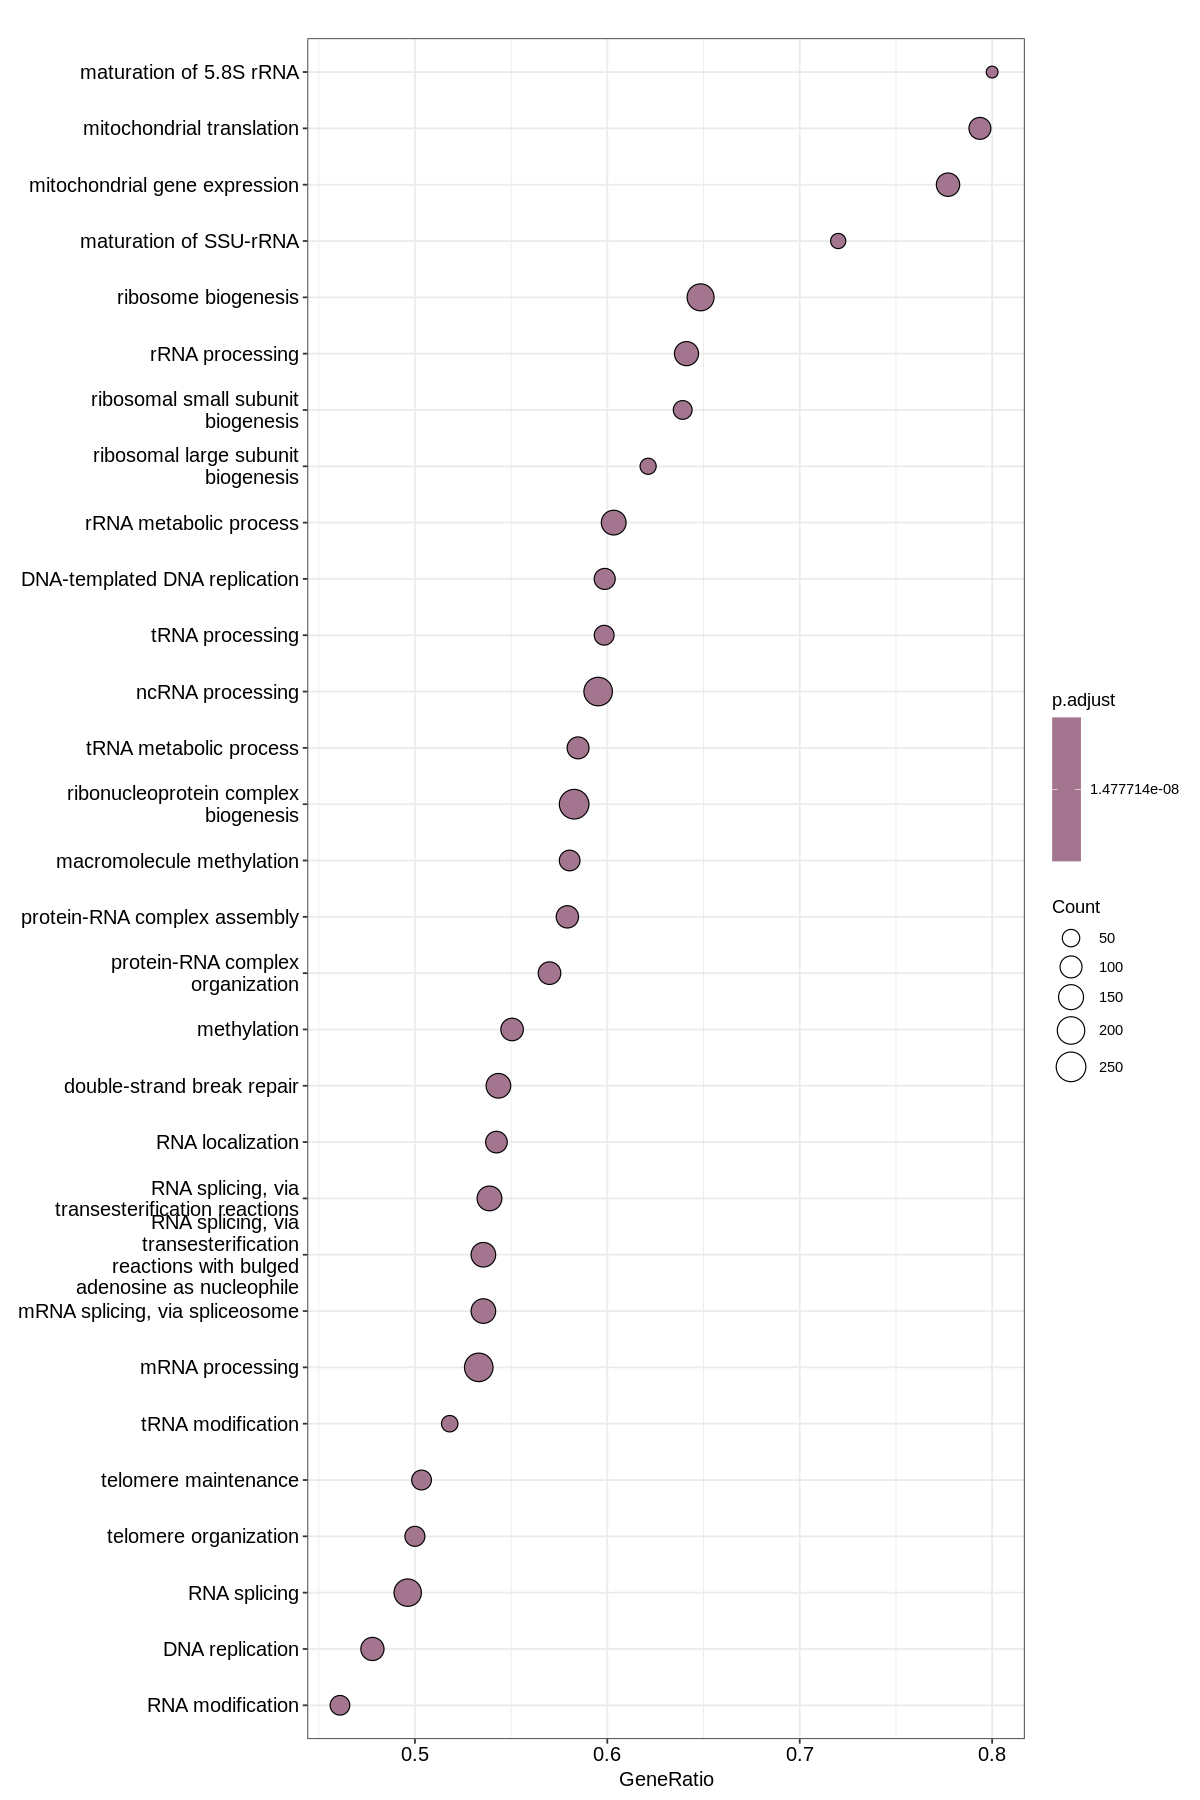

In [33]:
# A quick look of the data
options(repr.plot.width=10, repr.plot.height=15)

dotplot(gsea_result, showCategory = 30)


In [34]:
##make the data readable: replace entrez ID with gene symbol
readable_gsea_result <- setReadable(gsea_result, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")
write.csv(as.data.frame(readable_gsea_result ), file = "Readable_GSEA_results.csv")# save data

In [35]:
#Import the GSEA results of pathways of interest
GSE_GO_1<-as.data.frame(read.xlsx('/content/Readable_GSEA_results.xlsx'))

GSE_GO_1$p.adjust<-as.numeric(GSE_GO_1$p.adjust)
head(GSE_GO_1)

,X1,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,GO:0042254,GO:0042254,ribosome biogenesis,293,-0.6641985,-3.244894,1e-10,1.477714e-08,1.11187969924812e-08,2630,"tags=65%, list=22%, signal=52%",TRAF7/PIN4/SART1/SBDS/XPO1/NOL8/AATF/EXOSC10/USP16/DDX27/LSM6/FRG1/UTP23/MDN1/ERCC2/NVL/CHD7/ERAL1/TRMT61B/MALSU1/MTG2/UTP3/C1D/NGDN/EXOSC7/SUV39H1/EXOSC6/METTL17/DIMT1/WDR75/DDX47/XRN2/ZNF658/RPP30/RRP7BP/METTL5/EXOSC9/EXOSC5/KRI1/SNU13/RCL1/RPP38/RIOK2/ERI3/NOP58/NLE1/TSR3/MTERF3/RRP1B/NAT10/DDX18/ERI1/GNL2/EIF5/ZNHIT6/EIF6/PPAN/WDR36/POP4/UTP18/NAF1/NOP9/DDX10/SHQ1/KRR1/GNL3L/SURF6/EXOSC1/ESF1/RBFA/GEMIN4/PWP1/RPL7L1/EIF1AX/PRKDC/C1orf131/NHP2/TMA16/MPHOSPH10/BMS1/DDX31/POP7/NSUN5/DDX56/MRM1/NOL7/DHX29/EIF5B/DHX37/GTF3A/DDX52/UTP6/ABCE1/EXOSC3/NOM1/RAN/ISG20L2/LAS1L/MPHOSPH6/RIOK1/RPF1/DNTTIP2/NUP88/RPP25/EIF4A3/GTPBP4/XRCC5/FASTKD2/DDX51/DDX54/PES1/TFB2M/MRPS7/EXOSC8/PDCD11/SDAD1/LSG1/PWP2/DHX30/NOL10/HEATR1/NPM3/RPF2/DDX49/NOL11/IMP4/WDR3/RPUSD2/NOL9/SRFBP1/PA2G4/RPL26L1/TSR1/DKC1/EXOSC2/MRPL20/FTSJ3/WDR74/GAR1/RRP36/RRP7A/WDR18/NOC2L/HEATR3/TBL3/DCAF13/EXOSC4/MAK16/C1QBP/NIFK/DDX28/ZNF593/URB1/NIP7/WDR43/WDR46/RPUSD1/MYBBP1A/EMG1/BRIX1/NOC4L/FDXACB1/NOL6/RRP1/DDX21/WDR12/RRP12/UTP14A/PAK1IP1/BYSL/NOP2/LTV1/NOLC1/POP5/GRWD1/MRTO4/LYAR/UTP20/EBNA1BP2/UTP15/RRP15/RRP9/NOP56/PNO1/URB2/NOP16/MPV17L2/RRS1/BOP1/RPP40
2,GO:0016072,GO:0016072,rRNA metabolic process,242,-0.6389030,-3.150039,1e-10,1.477714e-08,1.11187969924812e-08,2418,"tags=60%, list=20%, signal=49%",DDX27/LSM6/FRG1/UTP23/SMARCB1/ERCC2/NVL/CHD7/GTF3C4/TRMT61B/UTP3/C1D/NGDN/EXOSC7/SUV39H1/EXOSC6/DIMT1/WDR75/DDX47/XRN2/RPP30/RRP7BP/METTL5/EXOSC9/EXOSC5/KRI1/SNU13/RCL1/RPP38/DIS3L/RIOK2/ERI3/NOP58/TSR3/RRP1B/NAT10/DDX18/ERI1/ZNHIT6/EIF6/PPAN/WDR36/POP4/UTP18/NAF1/SMARCA4/NOP9/DDX10/SHQ1/KRR1/EXOSC1/ESF1/RBFA/GEMIN4/PWP1/RPL7L1/PRKDC/NHP2/MPHOSPH10/BMS1/POP7/NSUN5/DDX56/MRM1/NOL7/DHX37/GTF3A/DDX52/UTP6/TAF1B/EXOSC3/LAS1L/MPHOSPH6/RIOK1/RPF1/RPP25/EIF4A3/GTPBP4/DDX51/DDX54/PES1/TFB2M/EXOSC8/PDCD11/TP53/PWP2/NOL10/HEATR1/NPM3/RPF2/DDX49/NOL11/IMP4/WDR3/RPUSD2/NOL9/SRFBP1/PA2G4/GTF3C6/TCOF1/TSR1/DKC1/MTOR/EXOSC2/FTSJ3/WDR74/GAR1/RRP36/RRP7A/WDR18/TBL3/DCAF13/EXOSC4/MAK16/NIFK/URB1/NCL/WDR43/WDR46/RPUSD1/POLR1B/EMG1/BRIX1/NOC4L/FDXACB1/NOL6/RRP1/DDX21/WDR12/RRP12/UTP14A/BYSL/NOP2/NOLC1/POP5/MRTO4/LYAR/UTP20/EBNA1BP2/UTP15/RRP15/RRP9/NOP56/RRS1/BOP1/RPP40
3,GO:0140053,GO:0140053,mitochondrial gene expression,157,-0.6321520,-2.975116,1e-10,1.477714e-08,1.11187969924812e-08,3520,"tags=78%, list=29%, signal=56%",MRPS24/WARS2/MRPL17/FASTKD1/MRPL33/FASTK/MRPS31/TARS2/RPUSD3/SUPV3L1/MRPS27/MRPL57/NDUFA7/CHCHD1/IARS2/MRPS30/MRPL50/MRPL9/GADD45GIP1/MRPL40/GFM2/MRPS2/MRPS33/TRIT1/MRPL14/PRKAA1/MRPS18A/MTRF1L/MRPL39/MRPS18B/GATB/MRPS25/TRNT1/MRPL34/MRPL22/TACO1/TEFM/AARS2/POLRMT/MRPL37/TBRG4/MRPL19/MRPS9/MRPL54/MTPAP/TRMT61B/MALSU1/MRPL51/MRPL55/MTG2/MRPL28/CHCHD10/AURKAIP1/MRPL42/COA3/SARS2/LRPPRC/MRPL13/MRPL36/DAP3/MRPL35/MTERF3/MRPL16/MRPS15/TRMT10C/MRPS35/YARS2/PTCD1/FASTKD5/MRPL11/MRPL41/FASTKD3/MRPS18C/CDK5RAP1/MRPL48/TFAM/MRPS16/MRPS22/QRSL1/MRPS34/MRPL52/EARS2/MRPS26/MRPL27/MRPL38/DARS2/MRPL23/MRPL18/MRPS28/TUFM/MRPS11/MRPL3/LARS2/FASTKD2/MRPS12/MRPS10/MRPL46/MRPL47/TFB2M/MRPS7/TRUB2/MRPL4/MRPS17/MRPS23/MRPL15/MRPL1/MRPL20/ELAC2/MRPL21/GFM1/MRPL24/TSFM/UQCC2/C1QBP/PUS1/MRPL12/PPARGC1B/MTG1/HSD17B10/SLC25A33/PNPT1/MPV17L2
4,GO:0008033,GO:0008033,tRNA processing,122,-0.6378924,-2.926857,1e-10,1.477714e-08,1.11187969924812e-08,2732,"tags=60%, list=23%, signal=47%",TRIT1/TP53RK/TRMT44/URM1/FAM98B/TRNT1/LSM6/CLP1/TYW1/MTFMT/LAGE3/METTL6/TRMT12/TRMT61B/MOCS3/TYW3/RPP14/GTPBP3/DTWD2/OSGEP/RPP30/TYW1B/RPP38/RTCB/PUS3/ANKRD16/TPRKB/NAT10/TRMT10C/PTCD1/FTSJ1/CDK5RAP1/POP4/PUSL1/ADAT1/TRDMT1/KTI12/FAM98A/TRMT10A/QTRT1/SSB/POP7/METTL2B/TSEN15/ELP6/ADAT3/RPP25/DDX1/METTL2A/TRMT6/DPH3/TRUB2/ALKBH8/DUS1L/TRMT1/NSUN2/ELAC2/LCMT2/PUS1/YRDC/PUS7/DUS3L/CTU2/TRMT61A/HSD17B10/P

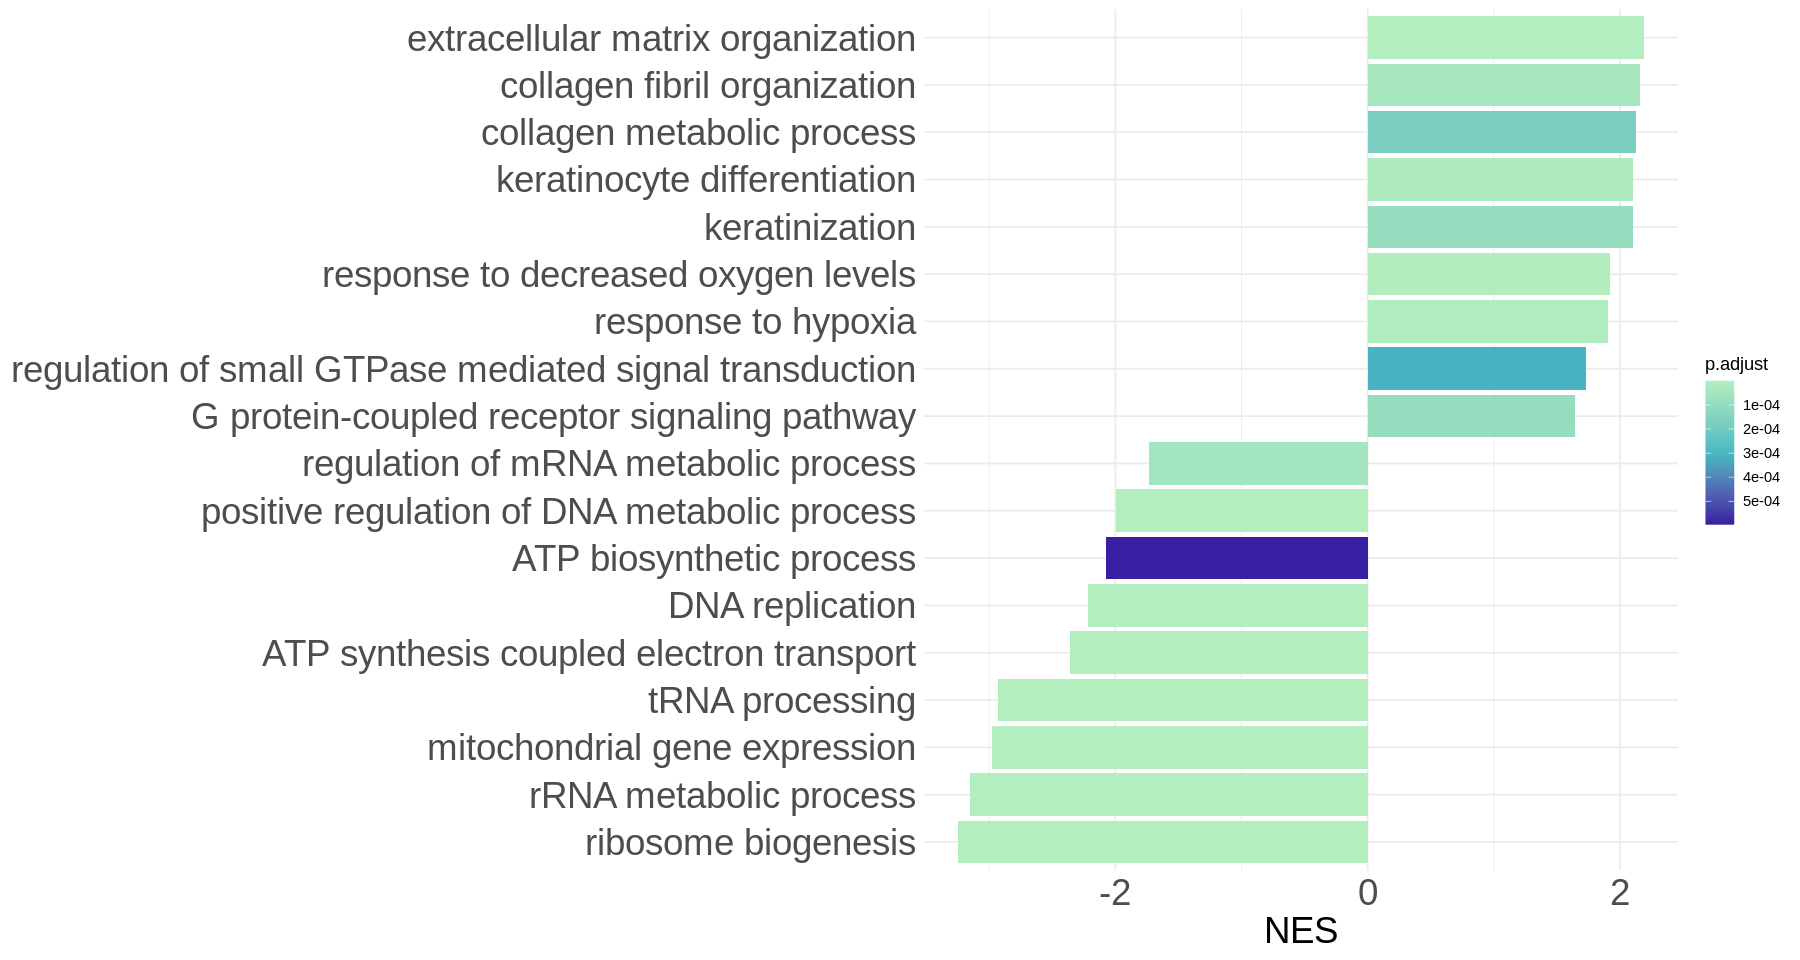

In [36]:
##Plot the pathway of interest
options(repr.plot.width=15, repr.plot.height=8)

ggplot(GSE_GO_1,
       aes(x=NES, y=fct_reorder(Description, NES), fill=p.adjust))+
  geom_col()+
  scale_fill_gradientn(colors=c("#b3eebe","#46bac2","#371ea3"), guide=guide_colorbar(reverse=TRUE))+
  theme_minimal() +
  theme(axis.text.y = element_text(size=22),axis.title.x = element_text(size=22),axis.text.x = element_text(size=22))+
  xlab("NES")+
  ylab(NULL)


In [39]:
## GSEA analysis of customized pathway from

Up_PEX<-as.data.frame(read.xlsx("/content/BATF depletion paper exhaustion up.xlsx"))
head(Up_PEX)
set_gene<-Up_PEX$Genes

#get entrez id from the established gene_list, to be consistent

head(Hyp_norm$genes)

Exhaust_genes<-Hyp_norm$genes[Hyp_norm$genes$genes %in% set_gene, ]
dim(Exhaust_genes)
head(Exhaust_genes)

#check NA values
na_in_Exhaust_genes <- is.na(Exhaust_genes)
na_Exhaust_genes <- colSums(na_in_Exhaust_genes)
print(na_Exhaust_genes)# no NA detected


,Genes
,<chr>
1,ACP5
2,ADGRG1
3,AFAP1L2
4,AKAP5
5,ANXA5
6,APOBEC3C


,genes,Entrez_ID,Ensembl_ID
,<chr>,<int>,<chr>
1,A1BG,1,ENSG00000121410
2,A1BG-AS1,503538,ENSG00000268895
12,AAAS,8086,ENSG00000291836
13,AACS,65985,ENSG00000081760
23,AAGAB,79719,ENSG00000103591
24,AAK1,22848,ENSG00000115977


[1] 125   3

,genes,Entrez_ID,Ensembl_ID
,<chr>,<int>,<chr>
190,ACP5,54,ENSG00000102575
376,ADGRG1,9289,ENSG00000205336
446,AFAP1L2,84632,ENSG00000169129
560,AKAP5,9495,ENSG00000179841
879,ANXA5,308,ENSG00000164111
967,APOBEC3C,27350,ENSG00000244509


     genes  Entrez_ID Ensembl_ID 
         0          0          0 


In [40]:
#generate pathway dataframe

Exhaust_ID<-Exhaust_genes$Entrez_ID

UP_EX_set<-data.frame(TermID="Terminal exhaust",gene_ID=Exhaust_ID)
head(UP_EX_set)

,TermID,gene_ID
,<chr>,<int>
1,Terminal exhaust,54
2,Terminal exhaust,9289
3,Terminal exhaust,84632
4,Terminal exhaust,9495
5,Terminal exhaust,308
6,Terminal exhaust,27350


using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are duplicate gene names, fgsea may produce unexpected results.”
leading edge analysis...

done...



                               ID      Description setSize enrichmentScore
Terminal exhaust Terminal exhaust Terminal exhaust     125       0.3287485
                      NES    pvalue  p.adjust qvalue rank
Terminal exhaust 1.216064 0.1421628 0.1421628     NA 3216
                                   leading_edge
Terminal exhaust tags=39%, list=27%, signal=29%
                                                                                                                                                                                                                                                                                                               core_enrichment
Terminal exhaust ACP5/LAYN/MYO7A/DDIT4/SNX9/PDCD1/KRT86/RGS1/KRT81/LAG3/VCAM1/RGS2/HAVCR2/ID3/CTLA4/MS4A6A/CD27-AS1/SIRPG/TNFRSF18/SARDH/TIGIT/STAT3/ADGRG1/GZMH/RBPJ/LYST/CCND2/IGFLR1/ENTPD1/PRDM1/SIT1/CD7/HLA-DRB6/ITM2A/PRKAR1A/TPI1/NAB1/RALGDS/MYO1E/CD27/CTSW/HLA-DRA/HLA-DMA/CD82/DUSP4/SYNGR2/HLA-DQB1/HLA-DQA1/CTSD


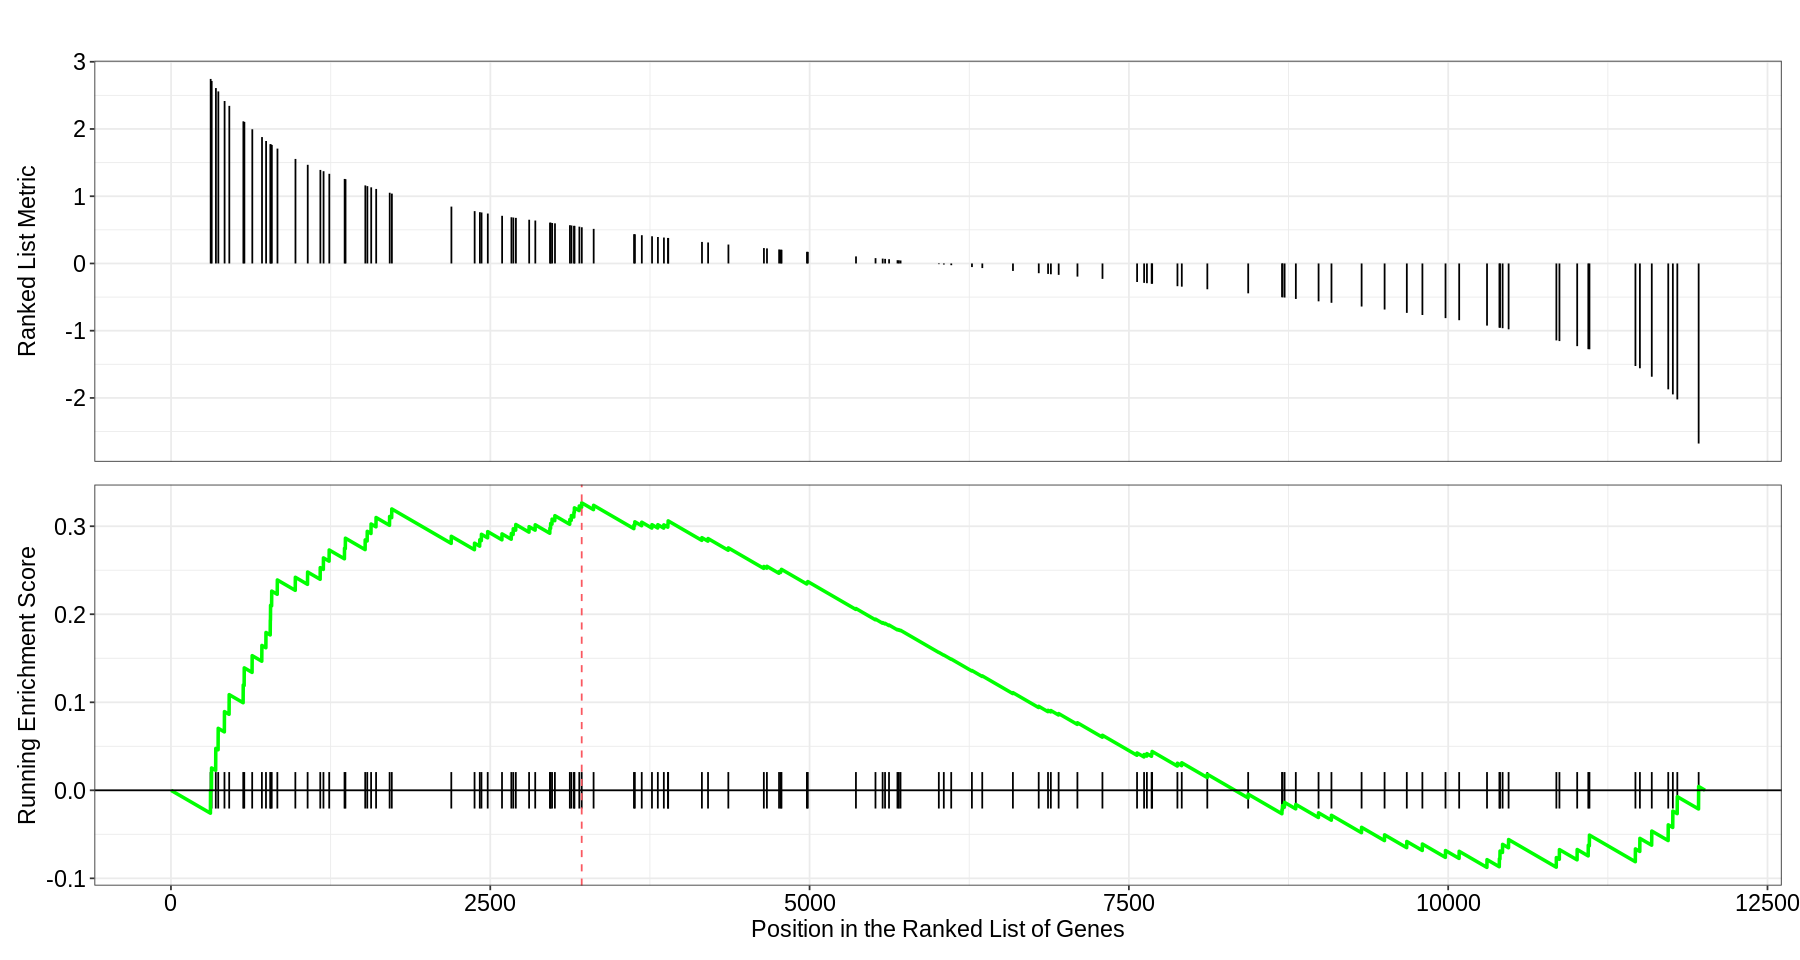

In [46]:
#Gsea analysis with exhaust gene set
Gseatex<-GSEA(geneList=GSEA_genes, TERM2GENE=UP_EX_set , pvalueCutoff = 0.5, pAdjustMethod = "fdr" )

Gseatex<-setReadable(Gseatex, OrgDb=org.Hs.eg.db,keyType = "ENTREZID")
gseaplot(Gseatex, geneSetID = "Terminal exhaust")
print(Gseatex@result) #NES 1.21, p value 0.142, not reaching significance